<a href="https://colab.research.google.com/github/dolmani38/ai_corona/blob/master/analysis_corona_0505.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Forecast with numeric timeseries data
# 1.1 Roaming Data의 load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
# custom R2-score metrics for keras backend
from keras import backend as K

def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def plot_mae(hist):
    plt.plot(hist.history['mae'])
    plt.title('mean_absolute_error')
    plt.ylabel('mae')
    plt.xlabel('Epoch')
    plt.legend(['mae'], loc='upper right')
    plt.show()

def plot_r2(hist):
    plt.plot(hist.history['r2'])
    plt.title('R square')
    plt.ylabel('R^2')
    plt.xlabel('Epoch')
    #plt.legend(['mae'], loc='upper right')
    plt.show()

def compare_backdata(predit_y):
    predit = []
    for forecast in range(forecast_days):
        predit.append(list(np.concatenate((np.zeros(window+ forecast), predit_y[:,forecast],np.zeros(forecast_days-forecast-1)), axis=0)))
    # 예측치를 chart에 같이 그려서 확인
    comp_ds = raw_ds.copy()
    comp_ds['predict_arrival_1'] = predit[0]
    comp_ds['predict_arrival_15'] = predit[14]
    comp_ds.plot(y=['total','predict_arrival_1','predict_arrival_15'],figsize=(16,8))

def display_result(predit_y):
    predic_ds = []
    # 로밍등록자는 실 입국자의 약 24%에 해당되므로.. 이를 보정 처리 한다.
    #predit_y1 = predit_y * 100/24
    from datetime import datetime, timedelta
    last_date = raw_ds.index[-1]
    for predict_count in predit_y[0]:
        last_date += timedelta(days=1)
        predic_ds.append({'date':last_date,'roaming register forecate':predict_count, 'immigrantion forecast':int(predict_count * 100/24)})
    predic_ds = pd.DataFrame(predic_ds)
    predic_ds.plot(x='date',y='immigrantion forecast',kind='bar')
    return predic_ds

class VerboseCallback(keras.callbacks.Callback):
    def __init__(self,epoch):
        self.epoch = epoch
        self.progress("learning:",0,[])
        
    def progress(self,text,current=0,log=None):
        pg = ['=' for i in range(current)] + ['.' for i in range(self.epoch-current)]
        print("\r" + str(text) + "[{}] {}/{} {}".format(''.join(pg),current,self.epoch, ('' if log is None else log)), end="", flush=True)
        if self.epoch-current == 0:
            print("")        
            
    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:",epoch+1,logs)



Using TensorFlow backend.


In [2]:
#공개된 Roaming Dataset을 읽고, 중간 중간 나온것을 합친다.
rm1 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/Roaming_data.csv",encoding="utf-8")
rm2 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/Roaming_data.csv",encoding="utf-8")
rm = pd.concat([rm1, rm2], ignore_index=True, sort=False)

# 합친 Dataset의 내용 확인
rm

,return,iso,arrival,departure,count
0,20200131,ad,20200130,20200130,3
1,20200131,ae,20191231,20200125,3
2,20200131,ae,20191231,20200131,3
3,20200131,ae,20200102,20200102,3
4,20200131,ae,20200104,20200131,3
...,...,...,...,...,...
217800,20200401,vn,20200330,20200401,3
217801,20200401,vn,20200331,20200331,20
217802,20200401,vn,20200331,20200401,6
217803,20200401,vn,20200401,20200401,45


In [3]:
# 1.2 Roaming Data에 대한 EDA
# 1.2.1 도착일을 기준으로 입국자(로밍등록자)의 합산

ar = pd.DataFrame(rm.groupby('arrival')['count'].sum())
ar['date'] =  ar.index.astype('object')
#date column을 datetime 으로 casting 한다.
ar['date'] =  pd.to_datetime(ar['date'], format='%Y%m%d')

# 날자별 입국자(로밍등록자) 정리 dataset 확인
ar

,count,date
arrival,,
20191031,91,2019-10-31
20191101,36,2019-11-01
20191102,120,2019-11-02
20191103,159,2019-11-03
20191104,179,2019-11-04
...,...,...
20200424,711,2020-04-24
20200425,463,2020-04-25
20200426,447,2020-04-26


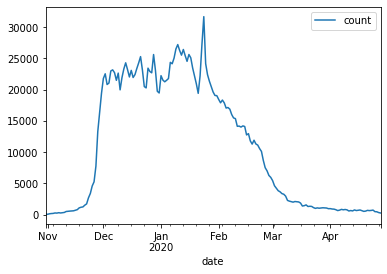

In [4]:
# 1.2.2 입국자(로밍등록자) 추세 chart 확인
ar.plot(x='date',y='count')

In [5]:
# 1.3 Roaming Data의 전처리
# 1.3.1 iso 별로 재배열

ar_iso = pd.DataFrame(rm.groupby(['arrival','iso'])['count'].sum())
rows = []
date = None
r = None
for row in ar_iso.iterrows():
    if date == row[0][0]:
        pass
    else:
        if not r is None:
            rows.append(r)
        r = {}
    r['arrival'] = row[0][0]
    r[row[0][1]] = row[1][0]
    date = row[0][0]
rows.append(r)
ds_iso = pd.DataFrame(rows)
ds_iso.fillna(0, inplace=True)
ds_iso = ds_iso.set_index('arrival')
ds_iso['total'] = ar['count']
ds_iso.index =  ds_iso.index.astype('object')
#index을 datetime 으로 casting 한다.
ds_iso.index =  pd.to_datetime(ds_iso.index, format='%Y%m%d')
ds_iso

,ae,at,cn,de,hk,jp,kh,kw,la,mm,my,no,pe,ph,pl,th,us,vn,hu,ma,mn,au,ch,fr,gb,in,iq,lk,qa,sg,uz,cz,dk,es,fi,id,nz,ru,sa,sk,...,tp,vu,zw,rs,tk,ug,bz,bo,cy,na,pg,rw,bt,lr,mz,pr,tg,mk,an,cv,tt,md,ad,ga,gn,re,ky,bf,bj,cf,tc,ls,td,mr,to,ws,gm,ye,ml,total
arrival,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31,3.0,3.0,20,3.0,6.0,6,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,8,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91
2019-11-01,0.0,0.0,6,3.0,0.0,3,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,9,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36
2019-11-02,0.0,0.0,26,6.0,3.0,9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6,19.0,3.0,0.0,0.0,0.0,6.0,3.0,6.0,3.0,6.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120
2019-11-03,3.0,3.0,30,0.0,12.0,14,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,13,21.0,6.0,3.0,0.0,0.0,0.0,3.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,9.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159
2019-11-04,12.0,3.0,40,3.0,3.0,10,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,6,24.0,9.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,6.0,6.0,3.0,0.0,0.0,3.0,3.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-24,0.0,12.0,84,34.0,19.0,157,0.0,0.0,0.0,3.0,3.0,0.0,0.0,30.0,0.0,18,62.0,44.0,6.0,0.0,3.0,3.0,0.0,9.0,12.0,6.0,0.0,0.0,0.0,6.0,6.0,0.0,6.0,3.0,0.0,28.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,711
2020-04-25,0.0,9.0,39,15.0,4.0,111,21.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,0.0,6,73.0,27.0,0.0,0.0,3.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463
2020-04-26,0.0,0.0,42,14.0,10.0,98,6.0,0.0,0.0,0.0,3.0,0.0,0.0,12.0,0.0,3,50.0,40.0,3.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,27.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,447


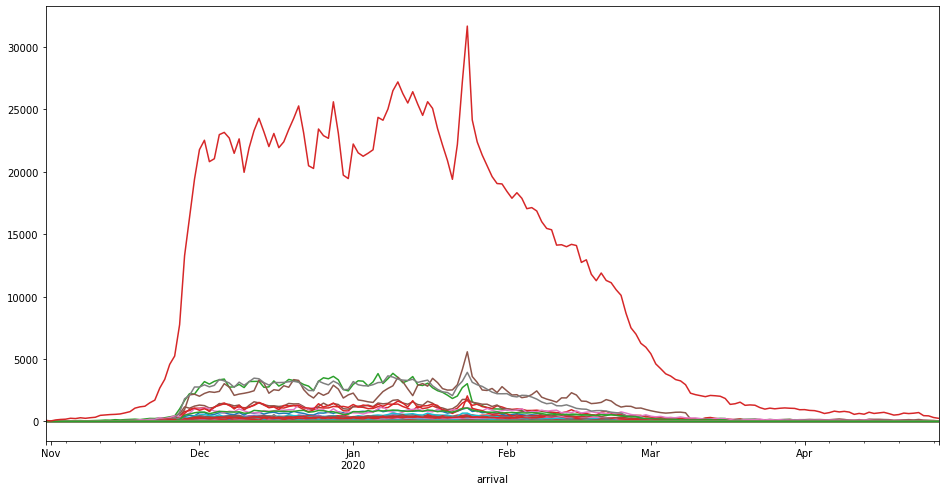

In [6]:
ds_iso.plot(legend=False,figsize=(16,8))

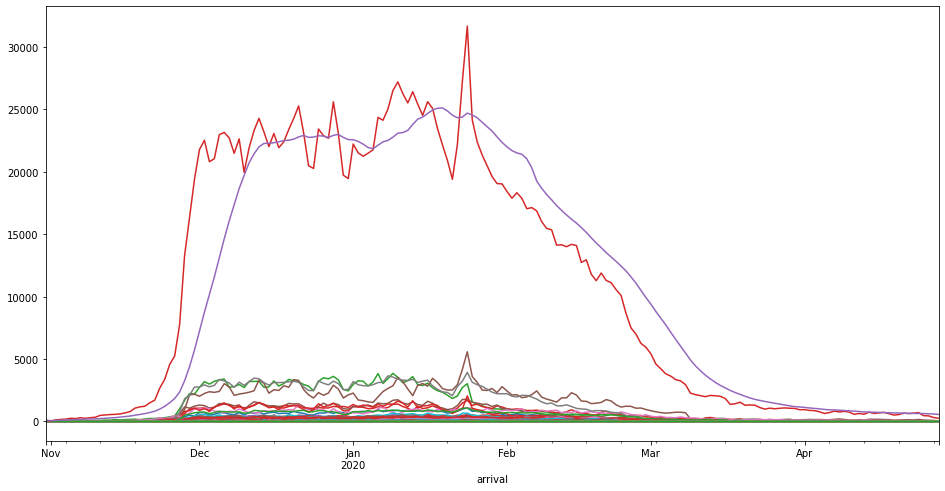

In [7]:
# 1.3.2 2주 (14일) 평균 추세 추가.
raw_ds = ds_iso.copy()
raw_ds['arrival_14ma'] = raw_ds['total'].rolling(window=14, min_periods=0).mean()
raw_ds.plot(legend=False,figsize=(16,8))

In [0]:
# 1.3.3 Trainingset의 구성

# Time-series CNN을 적용하기 위한 전처리
# 1D Convolution을 적용하기 위해.

import numpy as np

# window를 30일로 설정 -> 그냥 잡은 수치
window = 30
#입력 feature 개수.
size = len(raw_ds.columns) - 1 # totoal column 제외
#향후 15일 예측
forecast_days = 15


train_org_y = raw_ds['total'].to_numpy()
data = (raw_ds.drop(columns=['total'])).to_numpy()

train_x = []
train_y = []

for i in range(data.shape[0]-window-forecast_days + 1):
    sub_x = []
    for j in range(window):
        sub_x.append(data[i+j,:])
    train_x.append(sub_x)

    sub_y = []
    for z in range(forecast_days):
        sub_y.append(train_org_y[i + window + z])
    train_y.append(sub_y)

#train_x ,train_y의 준비
train_x = np.asarray(train_x)
train_x = train_x.reshape(-1,window,size)
train_y = np.asarray(train_y)

test_x = data[data.shape[0]-window:data.shape[0],:]

In [9]:
#train_x ,train_y의 내용 확인.
train_x.shape, train_y.shape, test_x.shape

((137, 30, 174), (137, 15), (30, 174))

In [10]:
# 1.4 CNN model 구성 


# 이게 최적의 layer 구성인지는 모름... 일반적/직관적으로 layer 설정 
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
from keras.models import Sequential

model = Sequential()
model.add(Conv1D(128,4, input_shape=(window, size),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 4,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

#model.add(Conv1D(32, 4,padding="same"))
#model.add(Activation('relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256))
model.add(Dense(forecast_days))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 128)           89216     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 64)            32832     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 448)              

In [11]:
# 1.5 model training
# 1.5.1 model training

#학습 시작...
epochs=100
hist = model.fit(train_x, train_y, epochs=epochs,verbose=0, callbacks=[VerboseCallback(epochs)])

learning:[====================================================================================================] 100/100 {'loss': 1432624.8841240876, 'mae': 677.9799, 'r2': 0.9858297}


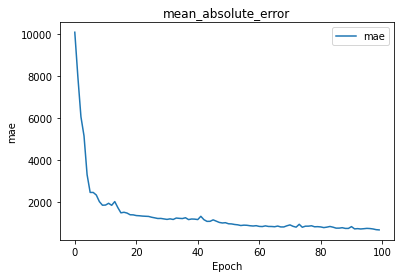

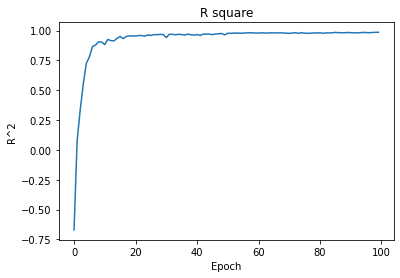

In [12]:
# 1.5.2 학습에 대한 mean_absolute_error 확인.
plot_mae(hist)
plot_r2(hist) 

In [13]:
# 1.5.3 trainset에 의한 과거 data의 예측 입국자 count 
predit_y = model.predict(train_x)
predit_y,predit_y.shape

(array([[19764.219  , 20504.916  , 20827.088  , ..., 22584.205  ,
         22691.643  , 22025.45   ],
        [21880.422  , 22582.19   , 23036.354  , ..., 24531.148  ,
         24817.045  , 24406.1    ],
        [22427.953  , 22966.053  , 23631.895  , ..., 24562.281  ,
         24864.883  , 24886.457  ],
        ...,
        [  495.6914 ,   522.0453 ,   462.62717, ...,   424.8625 ,
           424.21442,   429.5849 ],
        [  478.07123,   496.7508 ,   446.09576, ...,   394.61853,
           395.8394 ,   398.65436],
        [  454.05472,   477.90802,   428.53546, ...,   365.64105,
           374.39252,   373.60266]], dtype=float32), (137, 15))

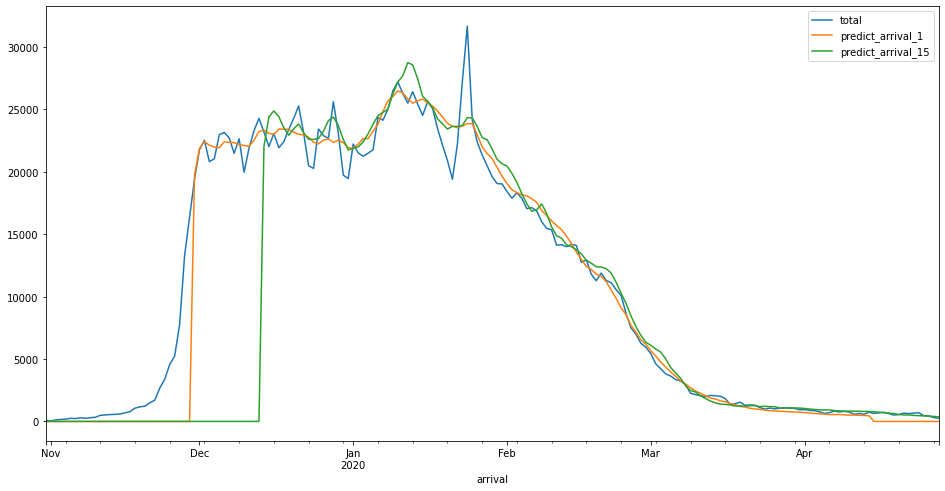

In [14]:
# 1.5.4 과거 Data에서 실등록자 count와 예측 count의 비교 

def compare_backdata(predit_y):
    predit = []
    for forecast in range(forecast_days):
        predit.append(list(np.concatenate((np.zeros(window+ forecast), predit_y[:,forecast],np.zeros(forecast_days-forecast-1)), axis=0)))
    # 예측치를 chart에 같이 그려서 확인
    comp_ds = raw_ds.copy()
    comp_ds['predict_arrival_1'] = predit[0]
    comp_ds['predict_arrival_15'] = predit[14]
    comp_ds.plot(y=['total','predict_arrival_1','predict_arrival_15'],figsize=(16,8))

compare_backdata(predit_y)

In [15]:
# 1.6  향후 15일 예측
# 1.6.1 testset (마지막 30일)의 inference

# trainset의 마지막 날에서 15일까지의 예측
# 마지막 30일치 정보를 input으로...

test_x = test_x.reshape(-1,window,size)
predit_y = model.predict(test_x)
predit_y, predit_y.shape

(array([[285.05676, 317.59   , 280.12274, 286.83334, 265.56332, 265.0949 ,
         298.72903, 276.8941 , 252.66756, 266.03732, 253.21211, 233.09438,
         200.34244, 213.71747, 214.20999]], dtype=float32), (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,285.056763,1187
1,2020-04-30,317.589996,1323
2,2020-05-01,280.122742,1167
3,2020-05-02,286.833344,1195
4,2020-05-03,265.563324,1106
5,2020-05-04,265.094910,1104
6,2020-05-05,298.729034,1244
7,2020-05-06,276.894104,1153
8,2020-05-07,252.667557,1052
9,2020-05-08,266.037323,1108


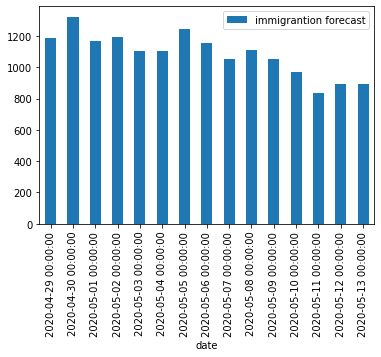

In [16]:
# 1.6.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출

display_result(predit_y)

In [17]:

# 	2.1 News Data의 load

# 뉴스 기사 정보를 읽어서... 나뉘어 있는 Dataset을 합친다.
ns1 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/NewsList.xls")
ns2 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/NewsList.xls")
ns =pd.concat([ns1, ns2], ignore_index=True, sort=False)
ns

,파일명,제목,URL,수집일자,게시일자,채널명,감염병명,분류명
0,AFRO2019120200003,WHO supports Angola’s Government efforts to en...,https://www.afro.who.int/news/who-supports-ang...,2019-12-02 21:00:16.0,2019-12-02 00:00:00,AFRO,Poliomyelitis,Viral
1,AFRO2019120300001,African First Ladies laud progress against HIV...,https://www.afro.who.int/news/african-first-la...,2019-12-03 00:00:17.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
2,AFRO2019120300002,Eritrea Observed World AIDS Day 2019,https://www.afro.who.int/news/eritrea-observed...,2019-12-03 00:00:18.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
3,AFRO2019120400003,West and Central Africa Expands Access to HIV ...,https://www.afro.who.int/news/west-and-central...,2019-12-04 03:00:14.0,2019-12-03 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
4,AFRO2019120400004,Nearly 23 million voluntary male medical circu...,https://www.afro.who.int/news/nearly-23-millio...,2019-12-04 22:00:14.0,2019-12-04 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
...,...,...,...,...,...,...,...,...
103822,XWFB2020040900020,"Ching Ming remembrance, home country forever! ...",http://wsjkw.sh.gov.cn/xwfb/20200404/2f54e0e14...,2020-04-09 16:05:21.0,2020-04-04 00:00:00,Shanghai Municioal Health Commission,COVID-19,Viral
103823,ZWYW2020041000002,Guangdong Provincial Health Commission notifie...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-10 18:00:45.0,2020-04-10 00:00:00,Health Commission of Guangdong Province,Dengue fever,Viral
103824,ZWYW2020041500002,Guangdong Provincial Health Commission announc...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-15 23:01:04.0,2020-04-15 00:00:00,Health Commission of Guangdong Province,Influenza,Viral
103825,ZWYW2020041500003,Guangdong Provincial Health Commission release...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-15 23:01:13.0,2020-04-15 00:00:00,Health Commission of Guangdong Province,Influenza,Viral


In [18]:
# 	2.2 News Data에 대한 EDA
# 		2.2.1 게시일을 기준으로 News buzz의 합산

cov_news = ns.loc[ns['감염병명'] == 'COVID-19']
cov_news['게시일자'] =  cov_news['게시일자'].str[:10]
cov_buz = pd.DataFrame(cov_news.groupby('게시일자')['감염병명'].count())
cov_buz = cov_buz.loc[cov_buz.index >= '2019-10-31']
cov_buz['date'] = pd.to_datetime(cov_buz.index, format='%Y-%m-%d')
cov_buz = cov_buz.rename(columns={"감염병명":"buz_count"})
cov_buz

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,buz_count,date
게시일자,,
2019-12-01,1,2019-12-01
2019-12-14,2,2019-12-14
2019-12-30,3,2019-12-30
2019-12-31,5,2019-12-31
2020-01-02,1,2020-01-02
...,...,...
2020-04-26,1176,2020-04-26
2020-04-27,1353,2020-04-27
2020-04-28,999,2020-04-28


In [19]:
# 		2.2.2 하루 최대 buzz count 추출

max_buz_per_day = cov_buz['buz_count'].max()
max_buz_per_day

1948

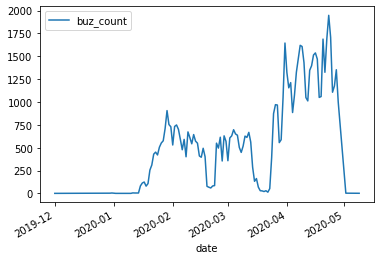

In [20]:
# 		2.2.3 News buzz 추세 Chart

cov_buz.plot(x='date',y='buz_count')

In [21]:
# Sentence Transformers: Multilingual Sentence Embeddings using BERT / RoBERTa / XLM-RoBERTa & Co. with PyTorch
# https://github.com/UKPLab/sentence-transformers

!pip install -U sentence-transformers

# BERT Test Code...

"""
This is a simple application for sentence embeddings: semantic search
We have a corpus with various sentences. Then, for a given query sentence,
we want to find the most similar sentence in this corpus.

This script outputs for various queries the top 5 most similar sentences in the corpus.
"""

from sentence_transformers import SentenceTransformer
import scipy.spatial

embedder = SentenceTransformer('bert-base-nli-mean-tokens')

# Corpus with example sentences
corpus = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'A cheetah is running behind its prey.'
          ]

corpus_embeddings = embedder.encode(corpus)

# Query sentences:
queries = ['A man is eating pasta.', 'Someone in a gorilla costume is playing a set of drums.', 'A cheetah chases prey on across a field.']
query_embeddings = embedder.encode(queries)

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
closest_n = 5

for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])
    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")
    for idx, distance in results[0:closest_n]:
        print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.6/dist-packages (0.2.6.1)




Query: A man is eating pasta.

Top 5 most similar sentences in corpus:
A man is eating a piece of bread. (Score: 0.8480)
A man is eating food. (Score: 0.7759)
Two men pushed carts through the woods. (Score: 0.2095)
A monkey is playing drums. (Score: 0.1945)
A man is riding a white horse on an enclosed ground. (Score: 0.1586)




Query: Someone in a gorilla costume is playing a set of drums.

Top 5 most similar sentences in corpus:
A monkey is playing drums. (Score: 0.7985)
A cheetah is running behind its prey. (Score: 0.2860)
The girl is carrying a baby. (Score: 0.2351)
A man is riding a horse. (Score: 0.2023)
A man is riding a white horse on an enclosed ground. (Score: 0.1963)




Query: A cheetah chases prey on across a field.

Top 5 most similar sentences in corpus:
A cheetah is running behind its prey. (Score: 0.9007)
Two men pushed carts through the woods. (Score: 0.3662)


In [22]:
# dolmani38의 google drive에서 corpus_embeddings.emb 의 다운로드
# corpus_embeddings.emb를 직접 만들거면 이 Cell은 실행 안해도 됨

!pip install PyDrive
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user(clear_output=False)
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({"id":"1FN7V0RxGACTNkusH9iQgFjXhicv1Lzei"})   # replace the id with id of file you want to access
downloaded.GetContentFile("corpus_embeddings.emb")        # replace the file name with your file

import os.path
from os import path

if path.exists("corpus_embeddings.emb"):
    print("Download complete!!")

Download complete!!


In [23]:
#			2.3.1.1 document의 tokenize & tagging
# 실 Contents는 사용하지 않고 title만 BERT embedding 처리...
import os.path
from os import path
import dill

if path.exists("corpus_embeddings.emb"):
    print("load from corpus_embeddings file...")
    file = open("corpus_embeddings.emb", 'rb')
    corpus_embeddings = dill.load(file)
    file.close()
    print("Complete!!")
else:
    temp_ds = cov_news #.head(10)
    corpus = []
    for row in temp_ds.iterrows():
        file_name = row[1][0]
        title = str(row[1][1])
        pub_datetime = row[1][4]
        corpus.append(title.lower())

    corpus_embeddings = embedder.encode(corpus,show_progress_bar=True)   

    print("Wait! saving corpus_embeddings...")    
    file = open("corpus_embeddings.emb", 'wb')
    dill.dump(corpus_embeddings, file)
    file.close()
    print("Complete!!")

corpus_embeddings = np.asarray(corpus_embeddings)        
print("shape of corpus_embeddings : ",corpus_embeddings.shape)

temp_ds = cov_news #.head(10)
docv_model = {}
for i, row in enumerate(temp_ds.iterrows()):
    docv_model[row[1][0]] = corpus_embeddings[i]

len(docv_model)

load from corpus_embeddings file...
Complete!!
shape of corpus_embeddings :  (73752, 768)


73306

In [24]:
#		2.3.4 원시(origin) Trainset의 구성

# BERT embedding 처리한 뉴스 원시 학습셋을 구성한다.
# 이때, 입국일자을 기준으로 Set을 만드는데...
# 입국일에 news가 없을 때도 있어서, 일관성 있는 양질의 학습셋이 되기는 어려울 듯...
# 준대로 해야지 어쩔 수 없음.

vec_size = corpus_embeddings.shape[1]
max_buz_per_day = 300 # 하루에 최대 300개의 뉴스를 본다. 나중에 실재 최대치까지 증가..
cov_news['게시일자'] = pd.to_datetime(cov_news['게시일자'], format='%Y-%m-%d')
news_metric = []
from datetime import datetime, timedelta
import numpy as np
# 날짜별 구성
for row in ar.iterrows():
    date = row[1][1]#datetime(2019,12,31)
    selected_ns = cov_news.loc[cov_news['게시일자'] >= date].loc[cov_news['게시일자'] < (date + timedelta(days=1))]
    #print(date,selected_ns.shape)
    if selected_ns.shape[0] == 0:
        # news가 없는 경우..
        news_metric.append(np.zeros((max_buz_per_day,vec_size)))
    else:
        docv = []
        for nrow in selected_ns.iterrows():
            #print('tag name:',nrow[1][0])
            if len(docv) < max_buz_per_day:
                docv.append(docv_model[nrow[1][0]])
        if len(docv) < max_buz_per_day:
            for i in range(max_buz_per_day-selected_ns.shape[0]):
                docv.append(np.zeros(vec_size))
        news_metric.append(docv)
        
train_temp_x = np.asarray(news_metric)
train_temp_x.shape


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(181, 300, 768)

In [25]:
# 학습셋의 label... 원시 train_temp_y의 구성
train_temp_y = np.asanyarray(ar['count'])
train_temp_y.shape

(181,)

In [26]:
#	2.4 doc2vec에 의한 Regression Test (Not forecast)
#		2.4.1 doc2vec의 Timeseries model 구성

# 일단, news regression의 설명력을 확인하기 위해...원시 학습을 test 한다.
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
from keras.models import Sequential

model = Sequential()
model.add(Conv1D(128,2, input_shape=(max_buz_per_day,vec_size),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 2,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 2,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 300, 128)          196736    
_________________________________________________________________
activation_4 (Activation)    (None, 300, 128)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 150, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 150, 64)           16448     
_________________________________________________________________
activation_5 (Activation)    (None, 150, 64)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 75, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 75, 32)           

In [27]:
#		2.4.2 원시(origin) Trainset으로 model training

epochs=50
hist = model.fit(train_temp_x, train_temp_y, epochs=epochs,verbose=0, callbacks=[VerboseCallback(epochs)])

learning:[==================================================] 50/50 {'loss': 41476382.77348066, 'mae': 4364.905, 'r2': 0.5770132}


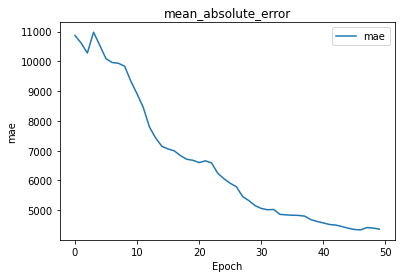

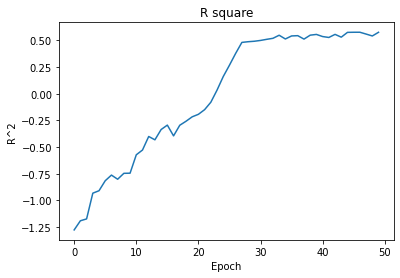

In [28]:
#		2.4.3 학습에 대한 mean_absolute_error 확인.

plot_mae(hist)
plot_r2(hist)

In [0]:
#		2.4.4 trainset에 의한 과거 data의 예측 입국자 count 
predit_y = model.predict(train_temp_x)
predit = predit_y.reshape(predit_y.shape[0])

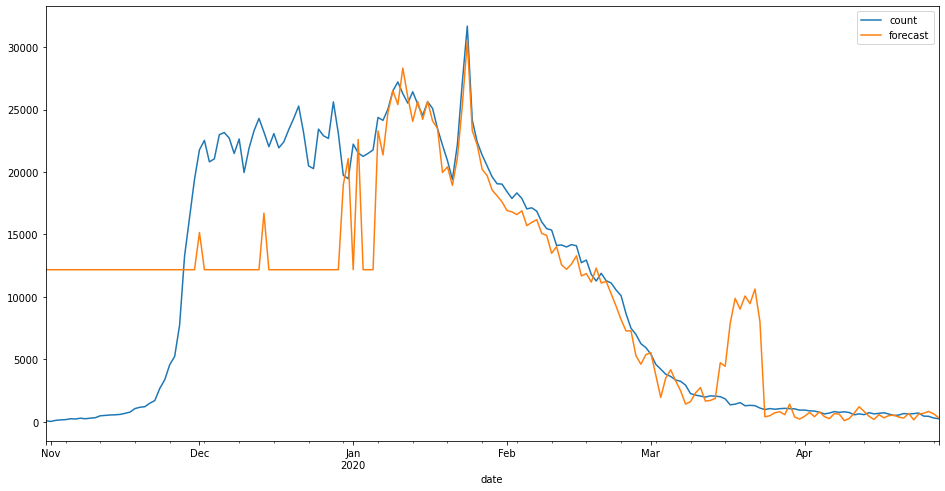

In [30]:
#		2.4.5 실등록자 count와 news기반 예측 count의 비교 chart
predit_result = ar.copy()
predit_result['forecast'] = predit
predit_result.plot(x='date',y=['count','forecast'],figsize=(16,8))

In [0]:
#	2.5 doc2vec에 의한 Forecast regression
#		2.5.1 doc2vec의 Window 적용 Timeseries Trainset의 구성

# 2D Convolution을 적용하여 마치 Image를 convolution 하듯이 학습할 것임
# window의 depth를 image의 channel 처럼 사용
# tensorflow는 image의 chennel을 channel_last로 사용, 
# 이것을 맞추기 위해 moveaxis 를 적용할 것임
# 여기 돌다가 colab 다운 잘됨... 다운 되면 처음부터 다시!

from numpy import moveaxis
# window를 30일로 설정 -> 그냥 잡은 수치
news_window = 30
#향후 15일 예측
news_forecast_days = 15

# 원시 trainset의 사용...
train_news_org_y = train_temp_y
data = train_temp_x

train_news_x = []
train_news_y = []

for i in range(data.shape[0]-news_window-news_forecast_days + 1):
    sub_x = []
    for j in range(news_window):
        sub_x.append(data[i+j,:,:])
    # change channels first to channels last format
    sub_x = np.asarray(sub_x)
    sub_x = moveaxis(sub_x, 0, 2)        
    train_news_x.append(sub_x)

    sub_y = []
    for z in range(news_forecast_days):
        sub_y.append(train_news_org_y[i + news_window + z])
    train_news_y.append(sub_y)

#train_news_x ,train_news_y 준비
train_news_x = np.asarray(train_news_x)
#train_news_x = train_news_x.reshape(-1,news_window,max_buz_per_day,vec_size)
train_news_y = np.asarray(train_news_y)

test_news_x = np.asarray(data[data.shape[0]-news_window:data.shape[0],:,:])
test_news_x = moveaxis(test_news_x, 0, 2) 

In [32]:
#train_news_x ,train_news_y (사실이거는 그냥 train_y와 동일...)의 내용 확인.
train_news_x.shape,  train_news_y.shape, test_news_x.shape

((137, 300, 768, 30), (137, 15), (300, 768, 30))

In [33]:
#		2.5.2 doc2vec Window 의 Timeseries model 구성

# 이게 최적의 layer 구성인지는 모름... 일반적/직관적으로 layer 설정 
# 정성적 비정형 데이터로 정량적 수치 데이터를 추정 하기 때문에... overfit 가능성이 큼
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

#keras.backend.set_image_data_format('channels_last')

model = Sequential()
model.add(Conv2D(64,(3,3), input_shape=(max_buz_per_day,vec_size,news_window)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(32,activation="relu"))
model.add(Dense(news_forecast_days))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 766, 64)      17344     
_________________________________________________________________
activation_8 (Activation)    (None, 298, 766, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 255, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 253, 32)       18464     
_________________________________________________________________
activation_9 (Activation)    (None, 97, 253, 32)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 84, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 86016)            

In [34]:
#		2.5.3 doc2vec의 Window 적용 Timeseries Trainset으로 model training

epochs=50
hist = model.fit(train_news_x, train_news_y, epochs=epochs,verbose=0, callbacks=[VerboseCallback(epochs)])


learning:[==================================================] 50/50 {'loss': 3608359.326642336, 'mae': 1358.9132, 'r2': 0.96153086}


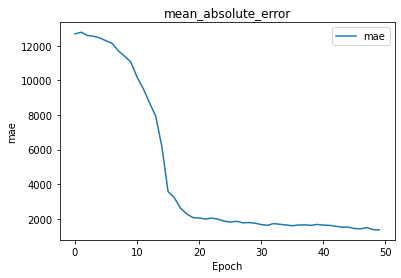

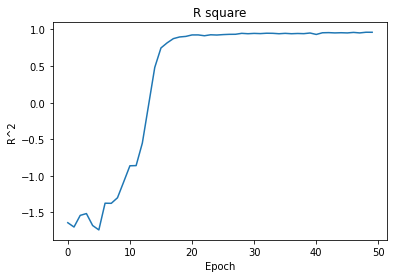

In [35]:
#		2.5.4 학습에 대한 mean_absolute_error 확인.

plot_mae(hist)
plot_r2(hist)

In [36]:
#		2.5.5 trainset에 의한 과거 data의 예측 입국자 추정 

predit_news_y = model.predict(train_news_x)
predit_news_y,predit_news_y.shape

(array([[22800.775  , 22813.29   , 22852.479  , ..., 21720.605  ,
         22383.225  , 22680.879  ],
        [22800.775  , 22813.29   , 22852.479  , ..., 21720.605  ,
         22383.225  , 22680.879  ],
        [23246.709  , 23232.639  , 23282.44   , ..., 22123.701  ,
         22769.756  , 23118.14   ],
        ...,
        [ 1345.9474 ,  1395.4625 ,  1158.7472 , ...,   833.6993 ,
           285.27795,   473.04535],
        [ 2176.9934 ,  2147.6416 ,  1800.1964 , ...,  1406.4086 ,
           751.07477,   725.1599 ],
        [ 4132.4683 ,  4149.2217 ,  3736.1853 , ...,  2907.4465 ,
          2355.0063 ,  1633.1964 ]], dtype=float32), (137, 15))

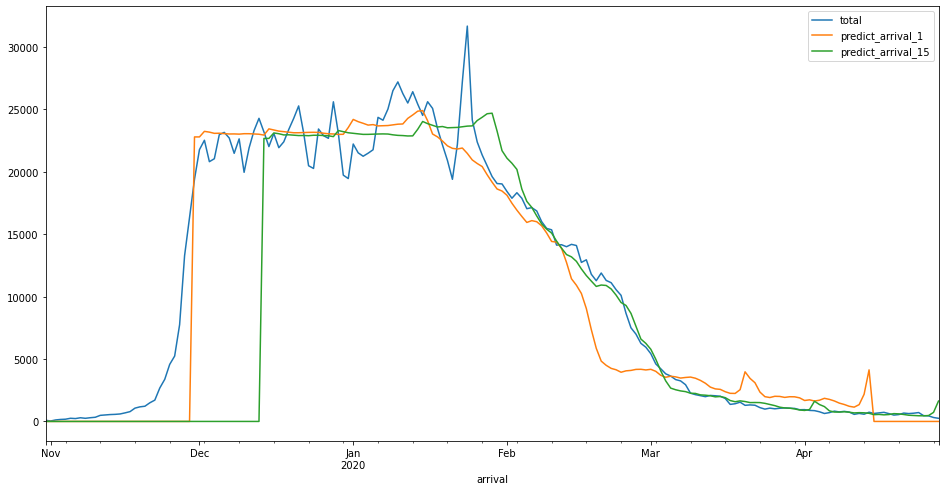

In [37]:
compare_backdata(predit_news_y)

In [38]:
# 	2.6  향후 15일 예측
# 		2.6.1 testset (마지막 30일)의 inference

test_news_x = test_news_x.reshape(-1,max_buz_per_day,vec_size,news_window)
predit_y = model.predict(test_news_x)
predit_y,predit_y.shape

(array([[1446.3792 , 1530.6586 , 1290.194  ,  948.02734, 1049.8475 ,
         1209.6284 , 1150.8096 ,  919.0715 ,  477.91553, 1111.8691 ,
         1032.0575 ,  655.0751 ,  901.8833 ,  281.85434,  538.97485]],
       dtype=float32), (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,1446.379150,6026
1,2020-04-30,1530.658569,6377
2,2020-05-01,1290.193970,5375
3,2020-05-02,948.027344,3950
4,2020-05-03,1049.847534,4374
5,2020-05-04,1209.628418,5040
6,2020-05-05,1150.809570,4795
7,2020-05-06,919.071472,3829
8,2020-05-07,477.915527,1991
9,2020-05-08,1111.869141,4632


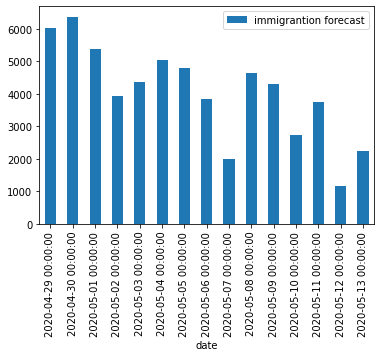

In [39]:

# 1.6.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출

display_result(predit_y)

In [40]:
train_x.shape

(137, 30, 174)

In [41]:
#	3.2 Numeric timeseries and unstructured timeseries combined model 구성
import keras
from keras import Input, Model
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, concatenate

# custom R2-score metrics for keras backend
from keras import backend as K

# define two sets of inputs
input_roaming = Input(shape=(window, size))
input_news = Input(shape=(max_buz_per_day,vec_size,news_window))

# 로밍등록자에 대한 1D Convilution layer 구성
x = Conv1D(128,4, activation="relu",padding="same")(input_roaming)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64,4, activation="relu",padding="same")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(32,4, activation="relu",padding="same")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Model(inputs=input_roaming, outputs=x)


# news에 대한 2D Convolution layer 구성
y = Conv2D(64,(3,3), activation="relu")(input_news)
y = MaxPooling2D(pool_size=(3,3))(y)
y = Conv2D(32,(2,2), activation="relu")(y)
y = MaxPooling2D(pool_size=(3,3))(y)
y = Flatten()(y)
y = Dense(1024,activation="relu")(y)
#y = Dropout(0.5)(y)
y = Dense(32,activation="relu")(y)
y = Model(inputs=input_news, outputs=y)

# combine the output of the two branches
combined = concatenate([x.output, y.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(forecast_days, activation="linear")(combined)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

print(model.summary())

model_json = model.to_json()
with open("combined_model.json", "w") as json_file:
    json_file.write(model_json)
json_file.close()

print("save to combined_model.json")

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 174)      0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 30, 128)      89216       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 300, 768, 30) 0                                            
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 15, 128)      0           conv1d_6[0][0]                   
____________________________________________________________________________________________

In [42]:
#	3.3 Numeric timeseries and unstructured timeseries data train

def train_combined_model(trial,epochs=30,verbose=0):
    from keras.models import model_from_json
    json_file = open("combined_model.json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])
    #print(model.summary())
    print(str(trial),"th Trial")
    if verbose == 0:
        hist = model.fit([train_x,train_news_x], train_y, epochs=epochs,verbose=0,callbacks=[VerboseCallback(epochs)])
    else:
        hist = model.fit([train_x,train_news_x], train_y, epochs=epochs,verbose=1)
    return model,hist

model,hist = train_combined_model(1,epochs=10)

1 th Trial
learning:[==========] 10/10 {'loss': 11055115.965328468, 'mae': 2194.5493, 'r2': 0.89494085}


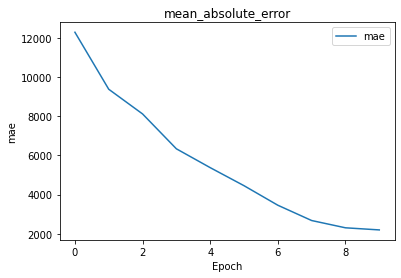

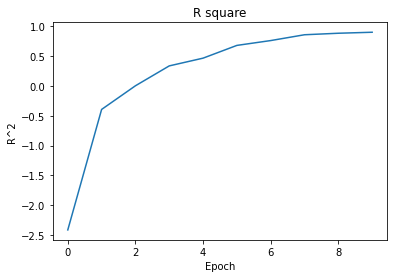

In [43]:
#		3.3.1 학습에 대한 mean_absolute_error 확인.

plot_mae(hist)
plot_r2(hist)

In [44]:
#		3.3.2 trainset에 의한 과거 data의 예측 입국자 count 

predit_y = model.predict([train_x,train_news_x])
predit_y,predit_y.shape

(array([[ 7772.7236 ,  7976.1196 ,  7346.054  , ...,  7503.5186 ,
          8303.738  ,  8470.097  ],
        [10517.693  , 10727.644  ,  9862.927  , ..., 10154.856  ,
         11165.333  , 11475.031  ],
        [13398.936  , 13630.601  , 12504.907  , ..., 13015.001  ,
         14135.987  , 14677.659  ],
        ...,
        [  506.26343,   507.85306,   438.2085 , ...,   204.89561,
           163.72403,   172.28725],
        [  494.74506,   497.2478 ,   427.4421 , ...,   213.21284,
           173.5637 ,   179.6325 ],
        [  481.99414,   487.12115,   418.06284, ...,   220.66504,
           179.23468,   178.31993]], dtype=float32), (137, 15))

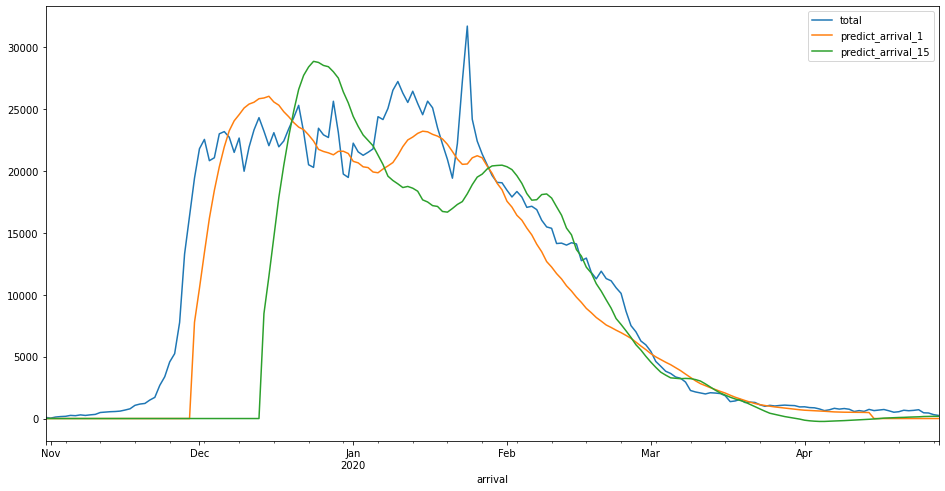

In [45]:
# window와 forecast_days에 의해 실제 날자와 차이나는 부분의 보정 처리...
compare_backdata(predit_y)

In [46]:
# 	3.4  향후 15일 예측
# 		3.4.1 testset (마지막 30일)의 inference

predit_y = model.predict([test_x,test_news_x])
predit_y,predit_y.shape

(array([[389.45087, 429.18857, 357.8073 , 295.61948, 364.3247 , 285.53238,
         308.00974, 282.02838, 267.14734, 238.7131 , 235.41919, 203.93607,
         276.51947, 223.99994, 172.63065]], dtype=float32), (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,389.450867,1622
1,2020-04-30,429.188568,1788
2,2020-05-01,357.807312,1490
3,2020-05-02,295.619476,1231
4,2020-05-03,364.324707,1518
5,2020-05-04,285.532379,1189
6,2020-05-05,308.009735,1283
7,2020-05-06,282.028381,1175
8,2020-05-07,267.147339,1113
9,2020-05-08,238.713104,994


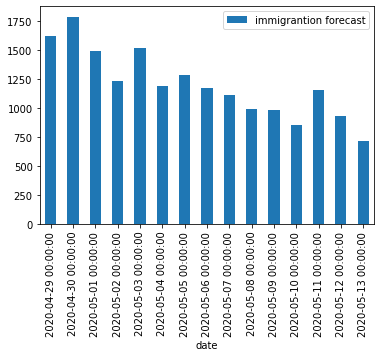

In [47]:
# 		3.4.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출

display_result(predit_y)

In [0]:
#	3.5 ensemble에 의한 일관된 결과 예측
#		3.5.1 ensemble model 생성

# 일관된 예측 결과를 만들기 위해, 동일 모델 10개의 앙상블 처리
# 시간 무지 오래 걸림 식사하고 오세요~
# 밥먹고 왔는데 중간에 실패 (Resource exhaustion) 되어 있을 수 있음...
# 너무 오래 걸리면, epoch=200 을 조정 한다.
import dill

ensemble = []
for i in range(10):
  model,hist = train_combined_model(i+1,epochs=50,verbose=0)
  ensemble.append(model)
    
#print("Wait! saving model...")    
#file = open("ensemble.mdl", 'wb')
#dill.dump(ensemble, file)
#file.close()
        
print("Complete!!")


1 th Trial
learning:[==================================================] 50/50 {'loss': 2791523.810218978, 'mae': 1077.1545, 'r2': 0.9674021}
2 th Trial
learning:[==================================================] 50/50 {'loss': 2507285.6642335765, 'mae': 1010.6712, 'r2': 0.97133243}
3 th Trial
learning:[==================================================] 50/50 {'loss': 2358504.4671532847, 'mae': 1010.7396, 'r2': 0.97205544}
4 th Trial
learning:[==================================================] 50/50 {'loss': 2565893.222627737, 'mae': 1049.8939, 'r2': 0.97348374}
5 th Trial
learning:[==============....................................] 14/50 {'loss': 7918571.352189781, 'mae': 2043.9832, 'r2': 0.91819715}

In [0]:
# 		ensemble_predict method define~
def ensemble_predict(input_roam,input_news):

    ensemble_predit_y =  np.asarray([m.predict([input_roam,input_news]) for m in ensemble])
    predit_y = np.mean(ensemble_predit_y,axis=0)
    return predit_y  

In [0]:
# trainset에 의한 과거 data의 예측 입국자 count 

predit_y = ensemble_predict(train_x,train_news_x)
predit_y,predit_y.shape

In [0]:
compare_backdata(predit_y)

In [0]:
# 
test_x = test_x.reshape(-1,window,size)
test_news_x = test_news_x.reshape(-1,max_buz_per_day,vec_size,news_window)

predit_y = ensemble_predict(test_x,test_news_x)
predit_y, predit_y.shape

In [0]:
#		3.5.2 최종 결과
display_result(predit_y)